In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Determine the optimal number of clusters for K-Means

## Imports

In [2]:
from collections import Counter

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from scipy.stats import chisquare
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

import umap

import torch

from src.metrics.distribution_measures import Encoder
from src.data.dataset_updated import MakeDataLoader
from src.utils import get_device

## Configs

In [3]:
path_encoder = '../models/cVAE/parameter_state_dict_Encoder.pth'
# dataset parameters
folder_images = '/home/kinakh/Datasets/galaxy-zoo/images_training_rev1/'
file_labels = '/home/kinakh/Datasets/galaxy-zoo/training_solutions_rev1.csv'
size = 64
augmented = False
batch_size = 64

# cluster parameters
min_cluster = 2
max_cluster = 50

device = get_device()

## Load encoder

In [4]:
encoder = Encoder()
ckpt = torch.load(path_encoder)
res = encoder.load_state_dict(ckpt)
print(f'Loading: {res}')

encoder.to(device)
encoder.eval();

Loading: <All keys matched successfully>


## Load data

In [5]:
make_dl = MakeDataLoader(folder_images, file_labels, size, augmented=augmented)
dl_train = make_dl.get_data_loader_train(batch_size=batch_size)

## Compute latents

In [6]:
latents = []

for images, _ in tqdm(dl_train):
    images = images.to(device)
    
    with torch.no_grad():
        mu, _ = encoder(images)
    latents.extend(mu.detach().cpu().numpy())
print(f'Number of latents: {len(latents)}')
latents = np.array(latents)

100%|██████████| 865/865 [01:38<00:00,  8.79it/s]

Number of latents: 55360


## 1. Display the data

### 1.1 Display t-SNE of the data

<IPython.core.display.Javascript object>


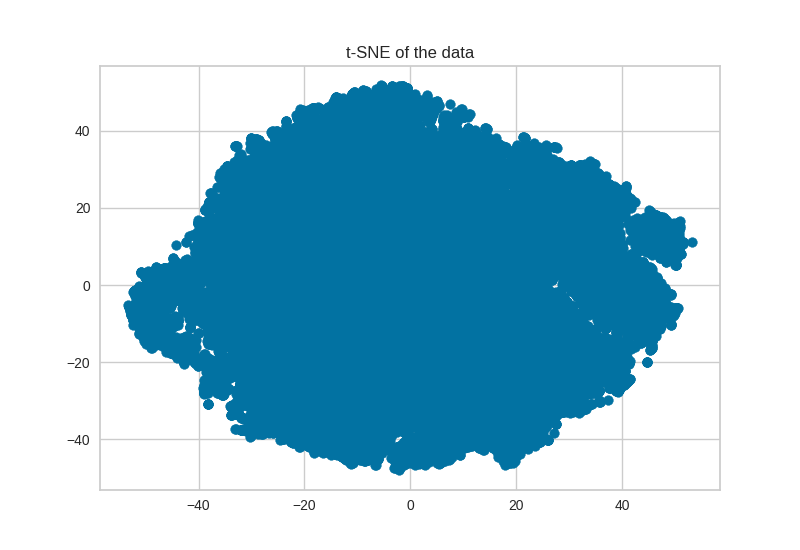

In [11]:
# tsne_emb = TSNE(n_components=2).fit_transform(latents)

plt.figure()
plt.title('t-SNE of the data')
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1])

No visible clustering

### 1.2 Display UMAP of the data

<IPython.core.display.Javascript object>


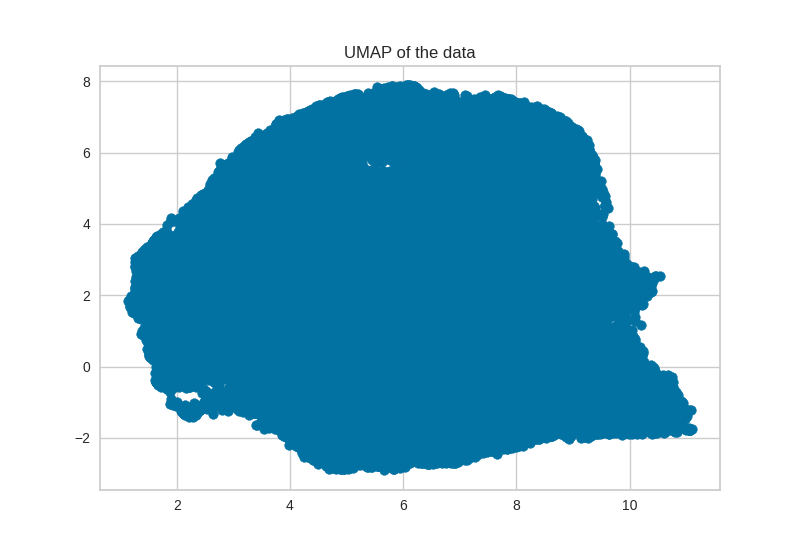

In [12]:
# umap_emb = umap.UMAP().fit_transform(latents)

plt.figure()
plt.title('UMAP of the data')
plt.scatter(umap_emb[:, 0], umap_emb[:, 1])

No visible clustering

## 2. Determine optimal number of the clusters

### 2.1 Use elbow method to determine best number of clusters

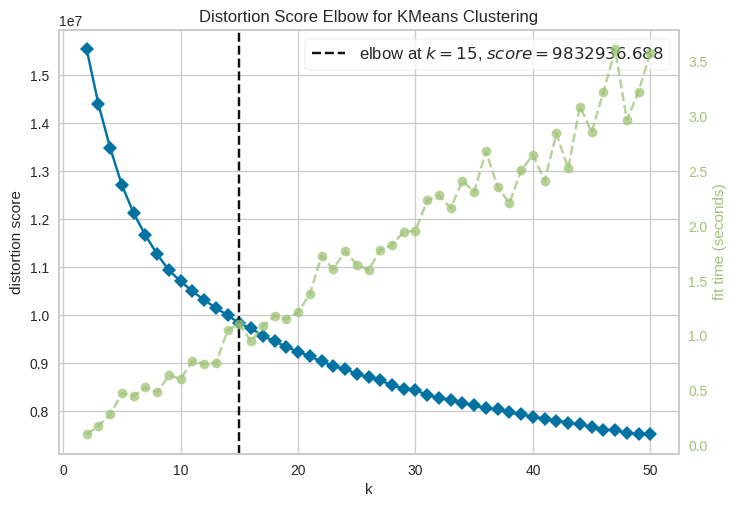

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(min_cluster, max_cluster + 1))
visualizer.fit(latents)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The best number of clusters is **12**

### 2.2 Use Calinski-Harabasz Index to determine optimal clusters

The Calinski-Harabasz index is also known as the Variance Ratio Criterion. It is the raPython'she sum of the between-clusters distance to intra-cluster distance (within the cluster) for all groups. A highe" scor" indicates better cluster compactness. It can be calculated using the KElbow visualizer from Py"hon’s "ellowBrick Library.

<IPython.core.display.Javascript object>


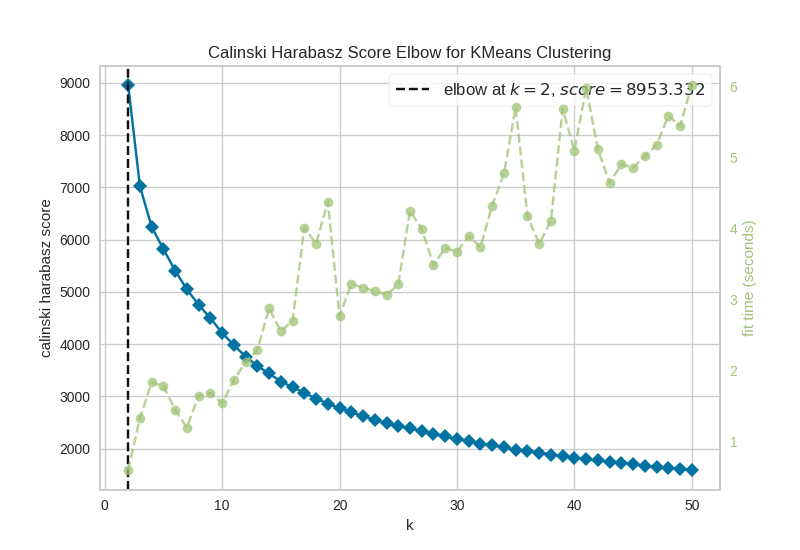

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [14]:
model = KMeans()
# k is a range of the number of clusters.
visualizer = KElbowVisualizer(
    model, k=(min_cluster, max_cluster + 1), metric="calinski_harabasz", timings=True
)
plt.figure()
visualizer.fit(latents)  # Fit the data to the visualizer
visualizer.show()  # Finalize and generate the plot

In [ ]:
# According to Calinski-Harabasz, the optimal number of clusters is **2**

### 2.3 Use silhouette score to select the best number of clusters

The silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters.


For each observation i, the silhouette width si is calculated as follows:

For each observation i, calculate the average dissimilarity ai between i and all other points of the cluster to which i belongs.
For all other clusters C, to which i does not belong, calculate the average dissimilarity d(i,C) of i to all observations of C. The smallest of these d(i,C) is defined as bi=minCd(i,C). The value of bi can be seen as the dissimilarity between i and its “neighbor” cluster, i.e., the nearest one to which it does not belong.
Finally the silhouette width of the observation i is defined by the formula: Si=(bi−ai)/max(ai,bi).

- Compute clustering algorithm (e.g., k-means clustering) for different values of k
- For each k, calculate the average silhouette of observations (avg.sil).
- Plot the curve of average silhouette according to the number of clusters k.
- The location of the maximum is considered as the appropriate number of clusters

In [10]:
silhouette_avgs = []

n_clusters = list(range(min_cluster, max_cluster + 1))

for n in tqdm(n_clusters):
    km = KMeans(n_clusters=n, n_init=10, max_iter=300, tol=1e-04, random_state=0)
    labels = km.fit_predict(latents)
    sil_avg = silhouette_score(latents, labels)
    
    silhouette_avgs.append(sil_avg)

100%|██████████| 49/49 [21:36<00:00, 26.46s/it]


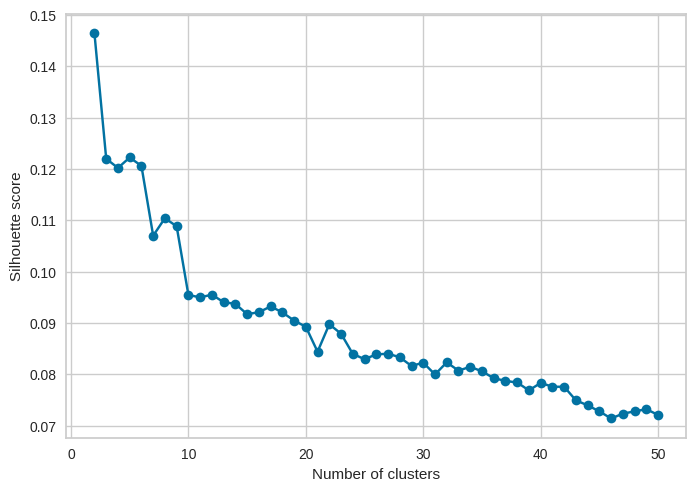

In [11]:
# plot
plt.plot(n_clusters, silhouette_avgs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [12]:
print(f'Optimal clusters: {n_clusters[np.argmax(silhouette_avgs)]}')

Optimal clusters: 2


Accrding to the **silhouette analysis** the best number of clusers is 2, meaning that distances between clusters is maximum when there are 2 clusters <br>
Though, optimal values are ~5 clusters or ~10 clusters, since we observe the bumps in the plot

### 2.4 Use gap statistic method to select the optimal number of clusters

The gap statistic compares the total within intra-cluster variation for different values of k with their expected values under null reference distribution of the data. The estimate of the optimal clusters will be value that maximize the gap statistic (i.e, that yields the largest gap statistic). This means that the clustering structure is far away from the random uniform distribution of points.

In [13]:
def gap_statistic_method(data: np.ndarray, nrefs: int = 3, maxClusters: int = 15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Args:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: 
        gaps, optimalK
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(trange(2, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):    
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

In [14]:
score_g, df = gap_statistic_method(latents, nrefs=5, maxClusters=max_cluster + 1)

100%|██████████| 49/49 [09:57<00:00, 12.19s/it]


Text(0.5, 1.0, 'Gap Statistic')

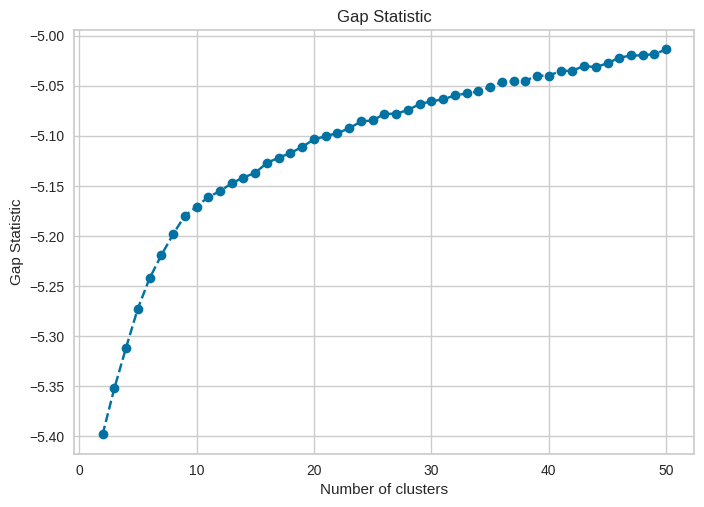

In [15]:
plt.figure()
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic')

In [16]:
print(f"Optimal clusters: {df['clusterCount'][np.argmax(df['gap'])]}")

Optimal clusters: 50.0


According to the Gap Statistics the best number of clusters is **50**

### 2.5 Use MeanShift to get the optimal number of clusters

In [17]:
mshift = MeanShift()
mshift.fit(latents)

cluster_centers = mshift.cluster_centers_
print(f'Num clusters: {len(cluster_centers)}')

Num clusters: 50


## 3 Analyze number of clusters

### 3.1 Silhouette Visualizer

The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering.

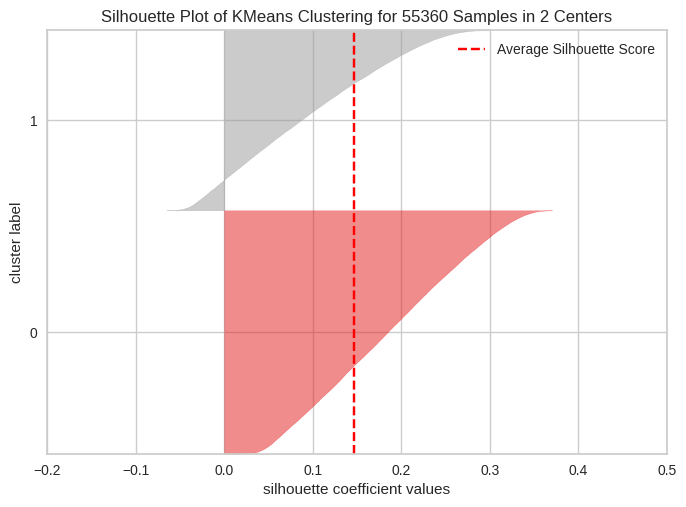

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
k = 2
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

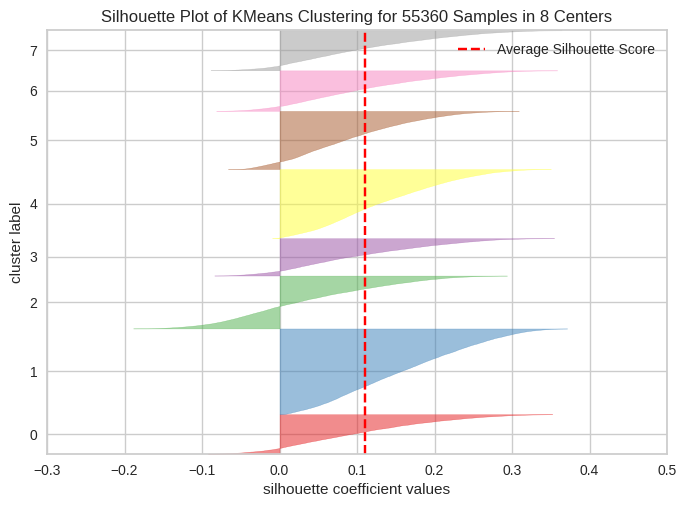

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
k = 8
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

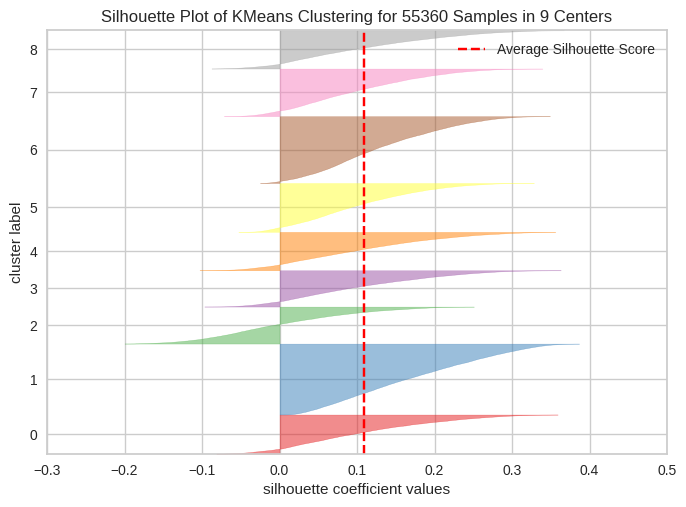

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
k = 9
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

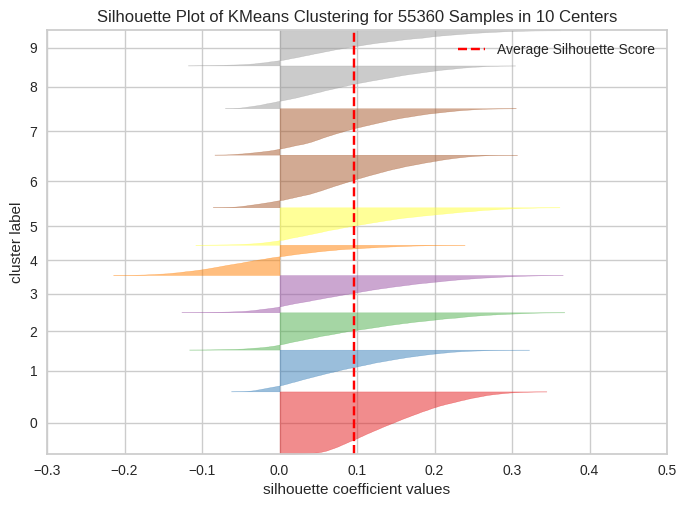

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
k = 10
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

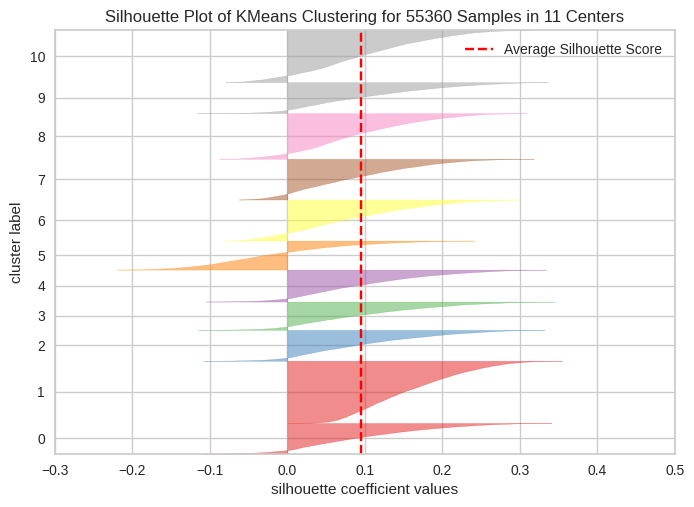

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 11 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
k = 11
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

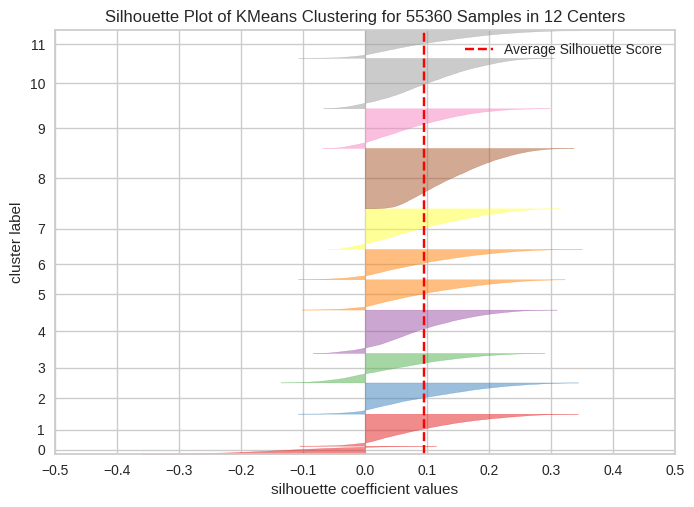

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 12 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:
k = 12
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

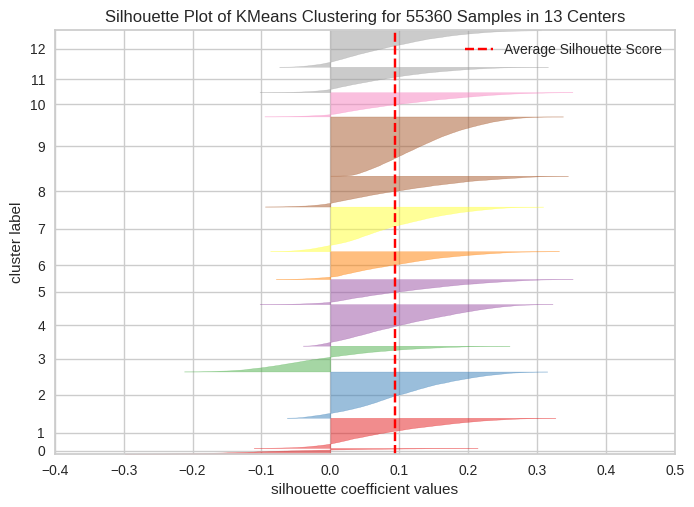

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 13 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
k = 13
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

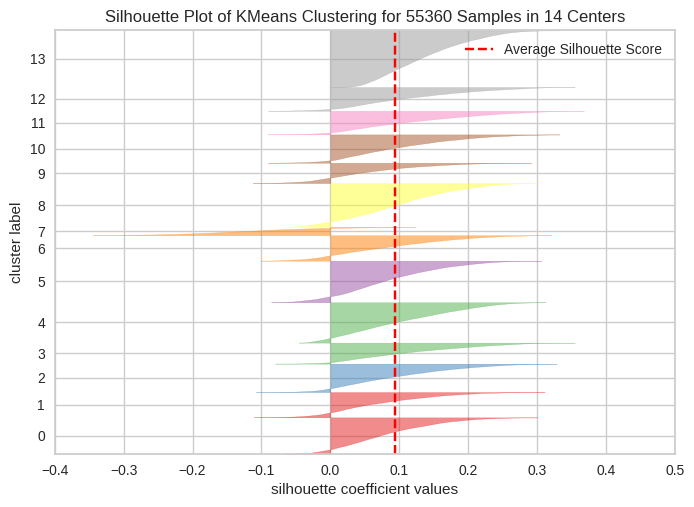

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 14 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
k = 14
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

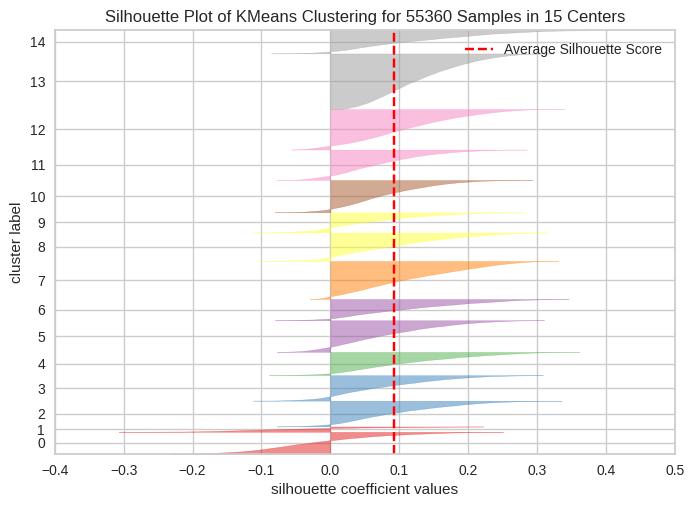

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 15 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
k = 15
model = KMeans(n_clusters=k, random_state=0)
visualizer = SilhouetteVisualizer(model, k=k)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

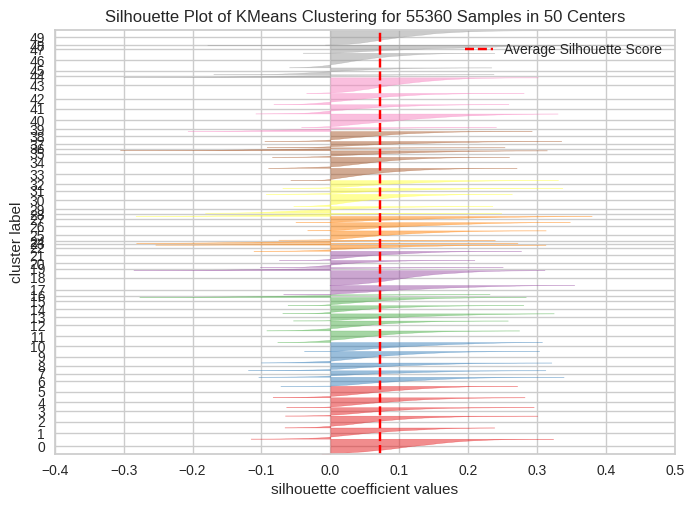

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 50 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
model = KMeans(n_clusters=50, random_state=0)
visualizer = SilhouetteVisualizer(model, k=50)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

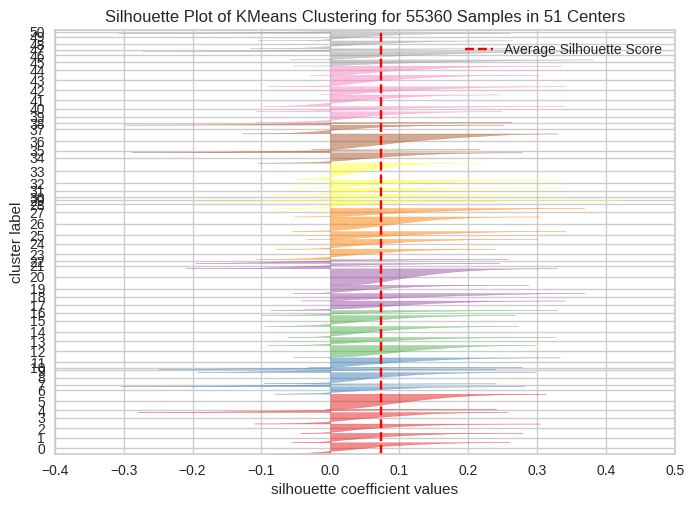

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 55360 Samples in 51 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
model = KMeans(n_clusters=51, random_state=0)
visualizer = SilhouetteVisualizer(model, k=51)

plt.figure()
visualizer.fit(latents)     # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### 3.2 Intercluster Distance Maps

Intercluster distance maps display an embedding of the cluster centers in 2 dimensions with the distance to other centers preserved. E.g. the closer to centers are in the visualization, the closer they are in the original feature space. The clusters are sized according to a scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.

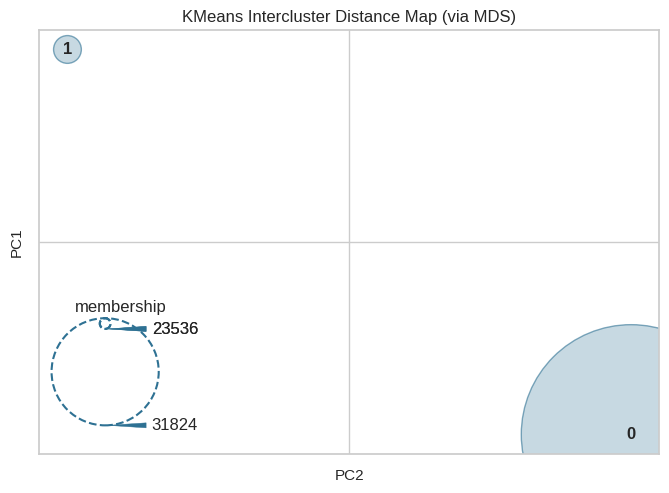

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [29]:
k = 2
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

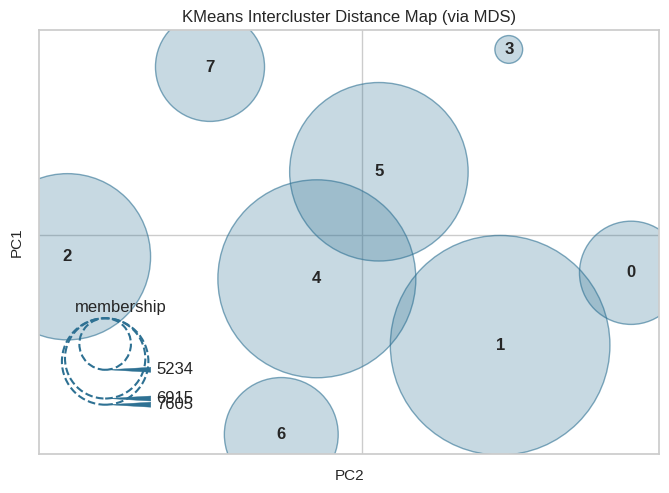

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [30]:
k = 8
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

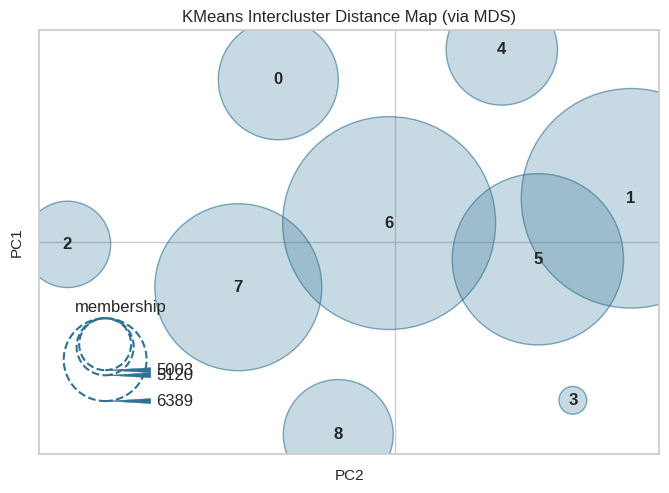

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [31]:
k = 9
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

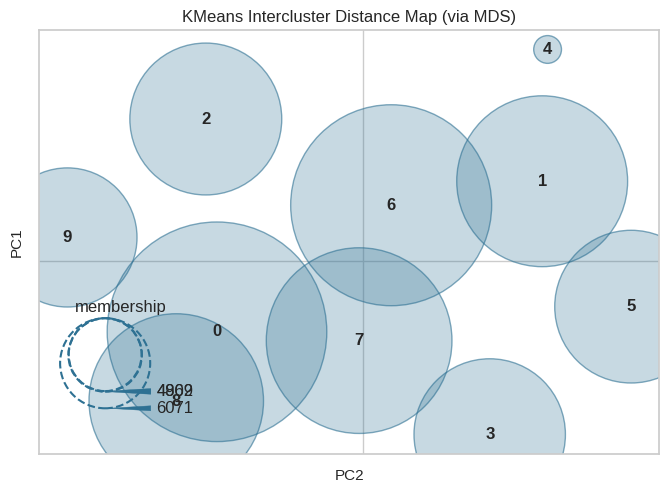

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [32]:
k = 10
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

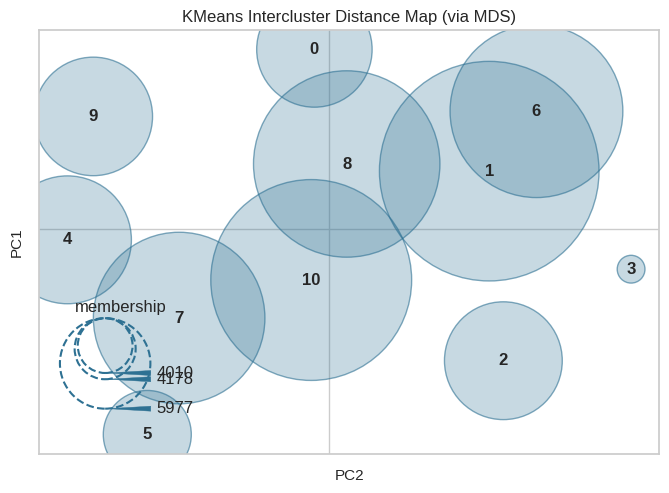

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [33]:
k = 11
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

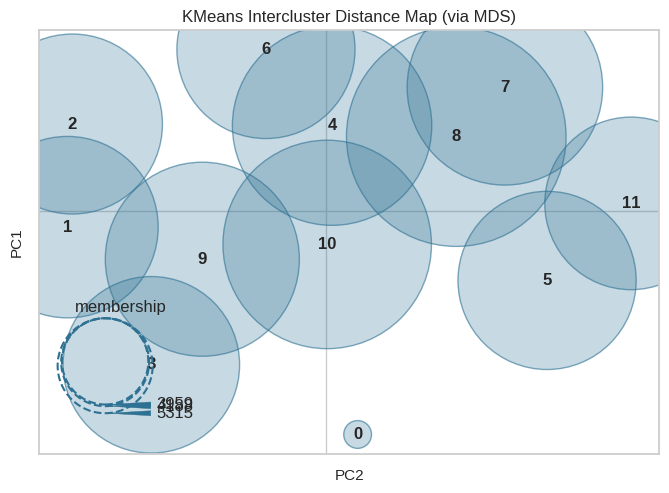

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [34]:
k = 12
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

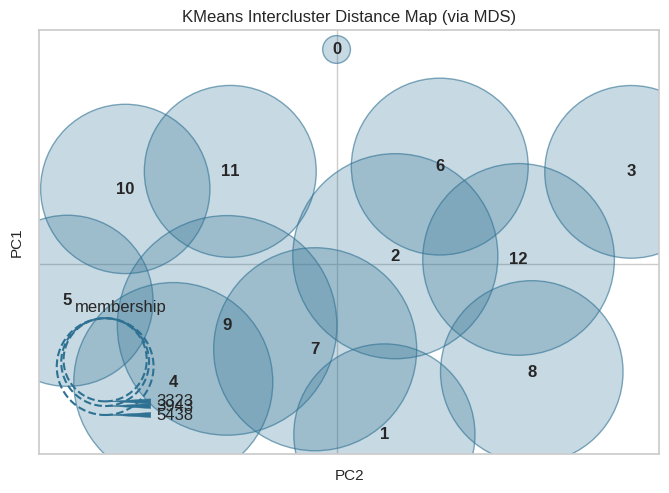

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [35]:
k = 13
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

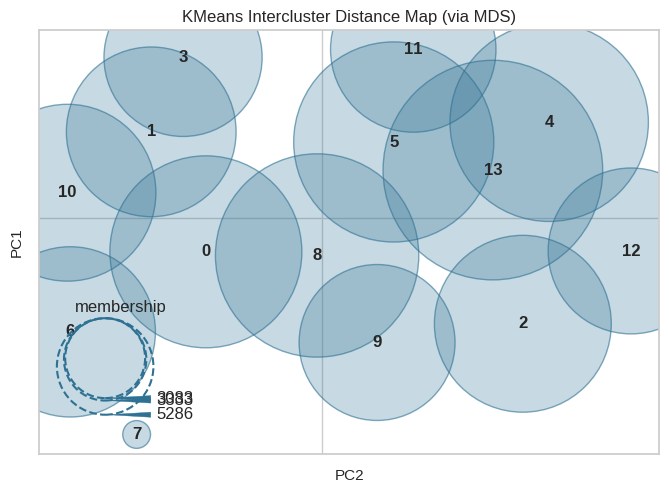

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [36]:
k = 14
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

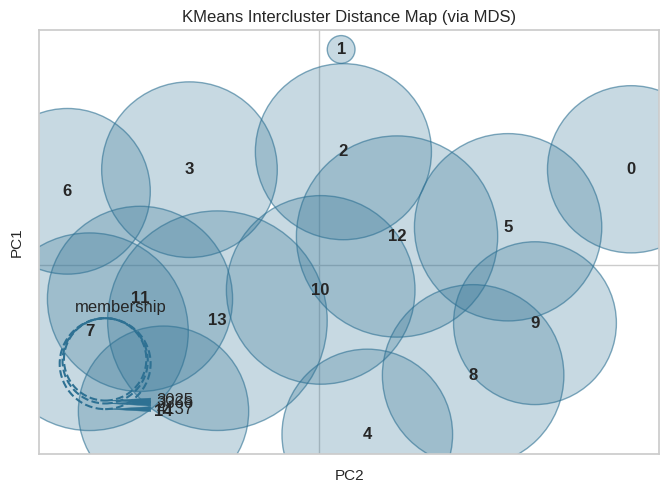

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [37]:
k = 15
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

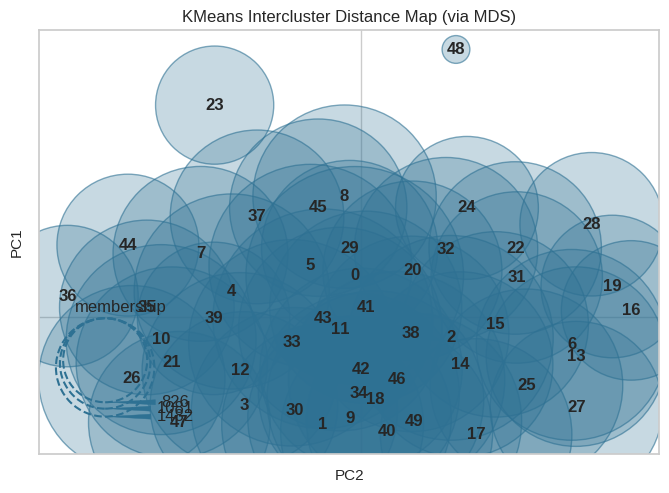

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [38]:
k = 50
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

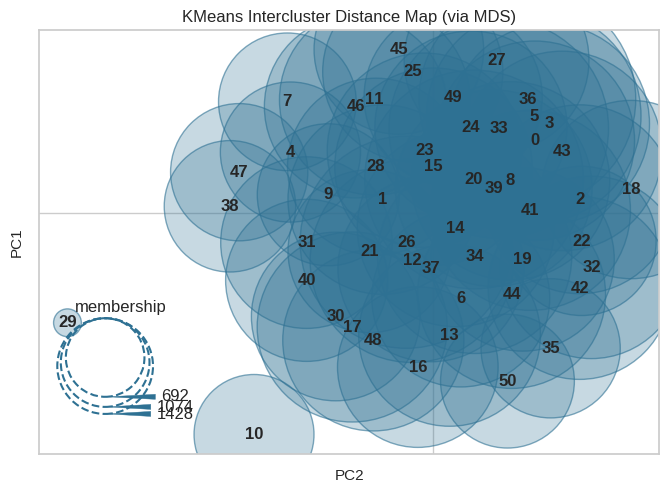

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [39]:
k = 51
model = KMeans(k, random_state=0)
visualizer = InterclusterDistance(model)

visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()              # Finalize and render the figure

### 3.3 Number of elem in each cluster

In [40]:
def rel_abs_error(values):
    values = np.array(values)
    
    values_sum = sum(values)
    n_clusters = len(values)
    
    expected = values_sum / n_clusters
    diff = np.abs(values - expected)
    return sum(diff) /  values_sum

Relative absolute error: 0.1507586705202312
chisquare pvalue: 0.880166089695456


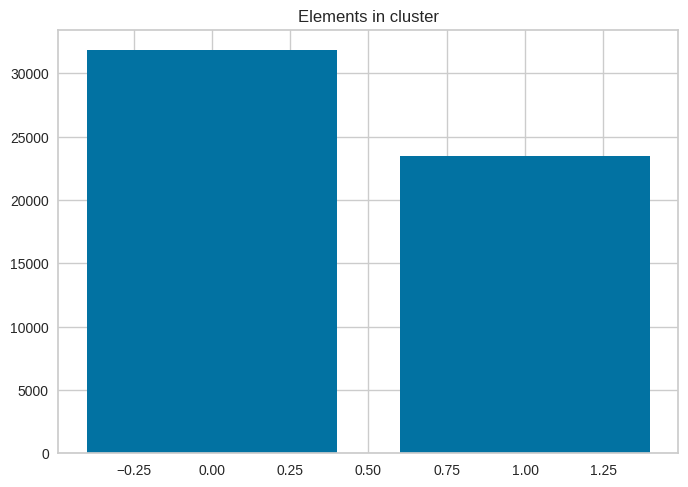

In [41]:
k = 2
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.2583815028901734
chisquare pvalue: 0.9999980405912825


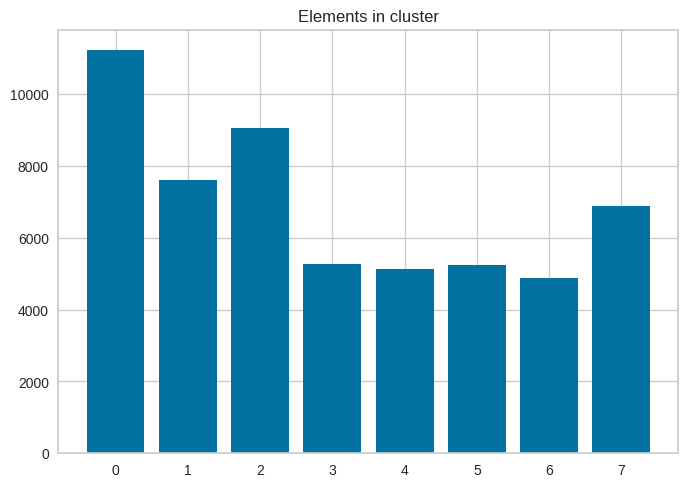

In [42]:
k = 8
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.21920359666024405
chisquare pvalue: 0.999999935443112


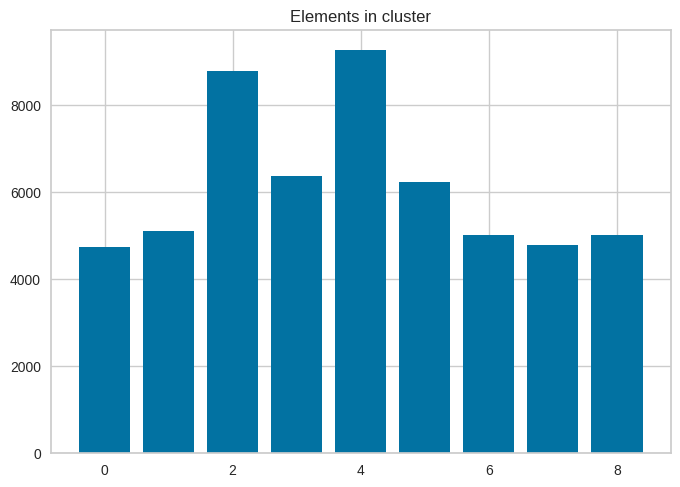

In [43]:
k = 9
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.16604046242774567
chisquare pvalue: 0.9999999992444126


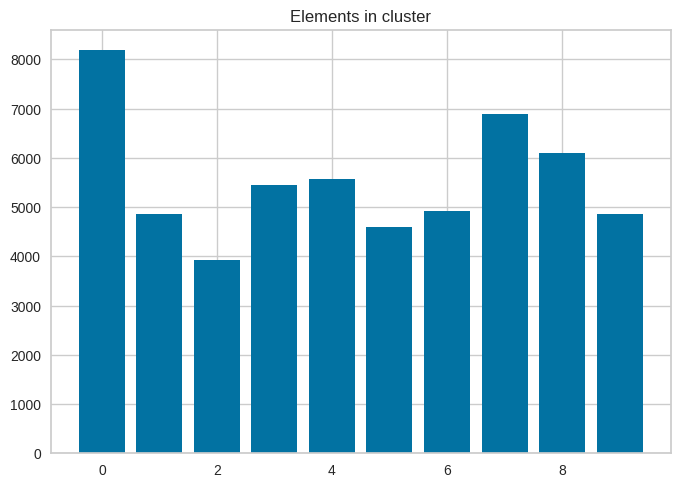

In [44]:
k = 10
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.23180504466631632
chisquare pvalue: 0.9999999994962785


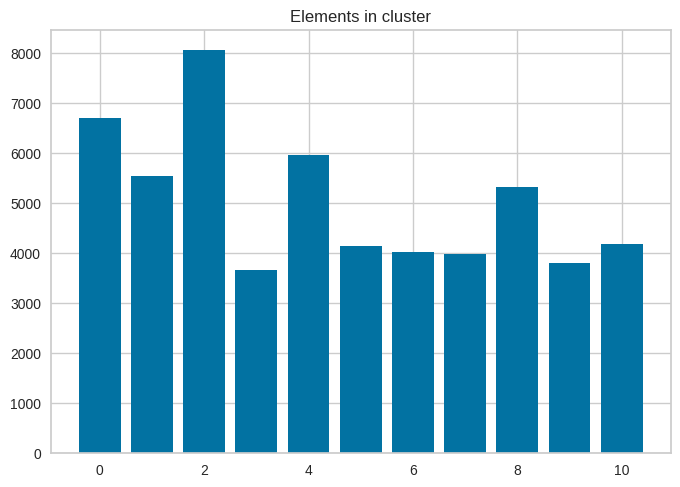

In [45]:
k = 11
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.2644629094412331
chisquare pvalue: 0.9999999998430315


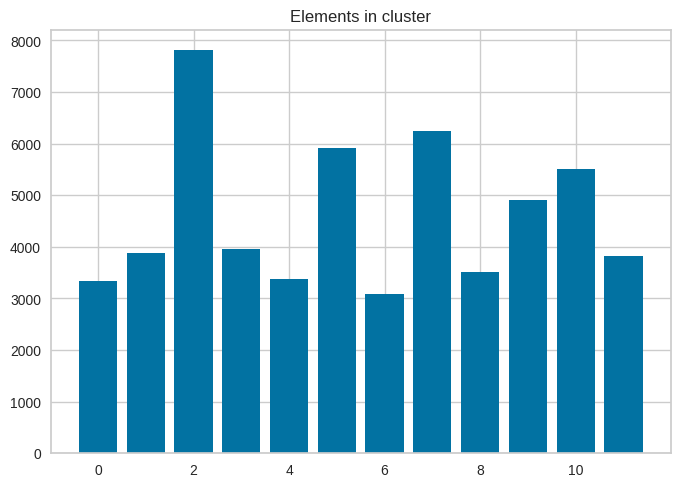

In [46]:
k = 12
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.2980380168963984
chisquare pvalue: 0.9999999998476917


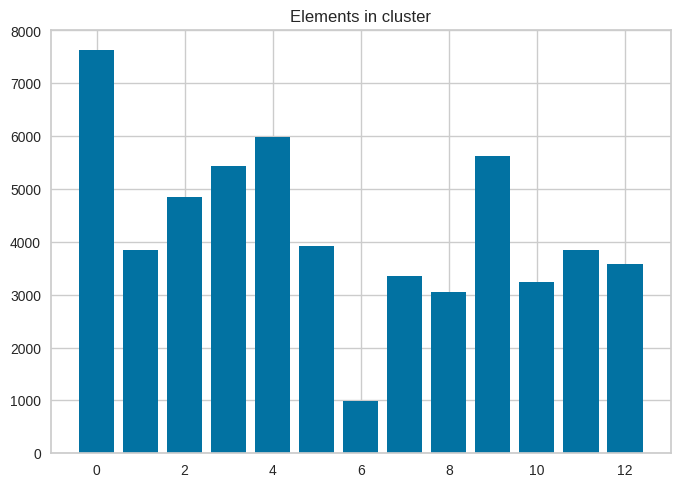

In [47]:
k = 13
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.3409888521882741
chisquare pvalue: 0.9999999998422824


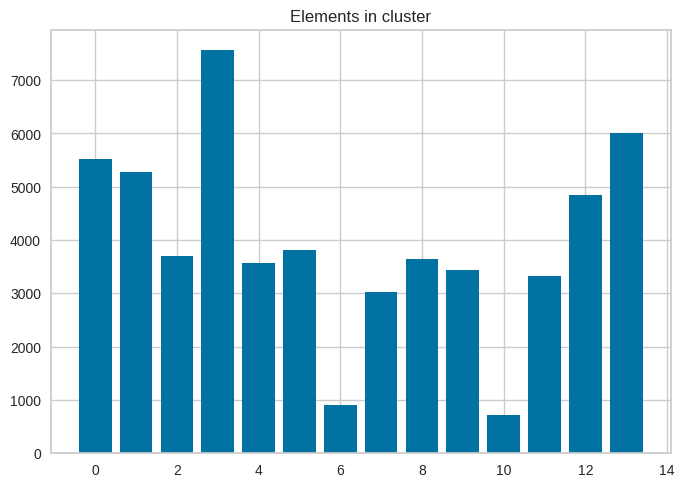

In [48]:
k = 14
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.35794797687861274
chisquare pvalue: 0.99999999997203


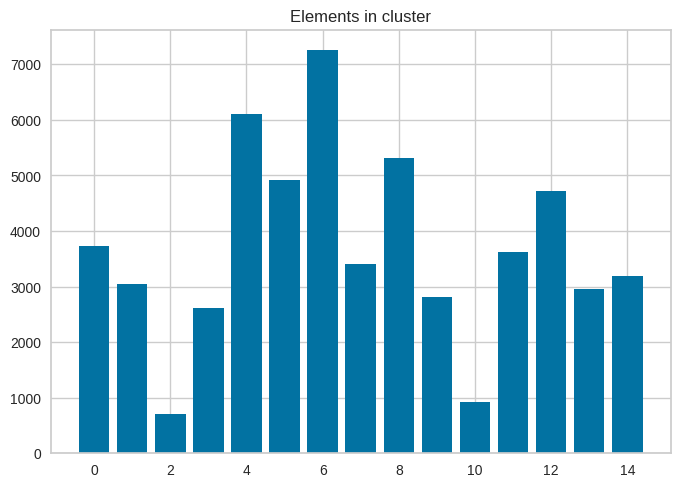

In [49]:
k = 15
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.3725216763005781
chisquare pvalue: 1.0


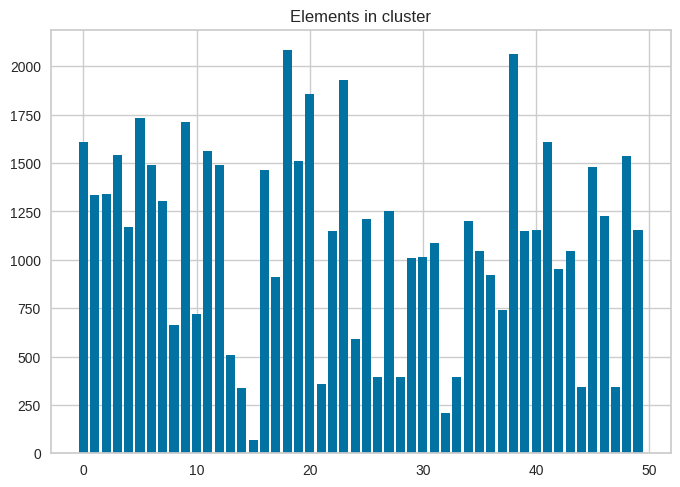

In [50]:
k = 50
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')

Relative absolute error: 0.3886659866258641
chisquare pvalue: 1.0


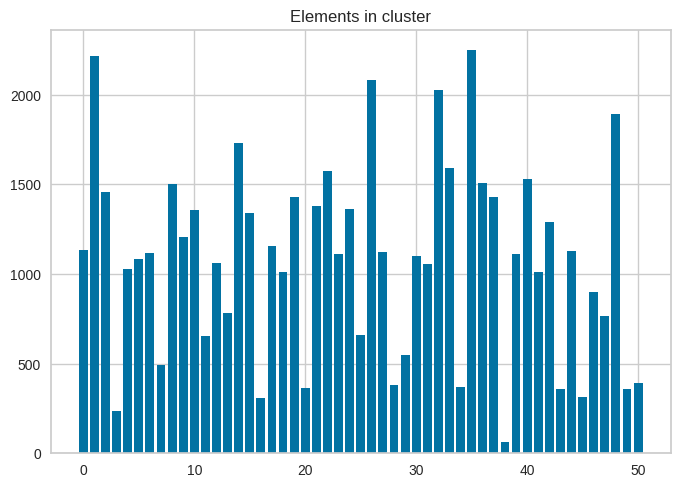

In [51]:
k = 51
km = KMeans(k)
pred = km.fit_predict(latents)
x_pos = list(range(k))

counter = Counter(pred)
keys = list(counter.keys())
values = list(counter.values())

plt.figure()
plt.title('Elements in cluster')
plt.bar(keys, values)

rae = rel_abs_error(values)
print(f'Relative absolute error: {rae}')

values = np.array(values) / latents.shape[0]
uniformness = chisquare(values).pvalue
print(f'chisquare pvalue: {uniformness}')